In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
import data_preperation as prep
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

In [2]:
#example of how to call preparation.py
import data_process as proc
import data_preperation as prep

In [3]:
#example of how to use data_process.py

#call data_preperation.py to get data 
measurement=prep.prepare_measurement()
forecast = prep.prepare_forecast()
#keep useful columns 
measurement= measurement[['speed', 'cos_wind_dir', 'sin_wind_dir', 'temp', 'radiation', 'precip', 'season', 'am']]

#call data_process.py
x_df, y_df, x, y = proc.prepare_x_y(measurement, forecast, 24, 24, 'speed') 

read csv semester csv files from 2015s2 to 2020s1
smooth wind direction
generate seasonality categorical feature
generate am/pm categorical feature
reading forecast data
smooth wind direction


In [ ]:
# ------- extended code of data_process.py file ------- 

In [4]:
#get measurement data and forecast data: 
df0=prep.prepare_measurement()
forecast = prep.prepare_forecast()
df0 = df0[['speed', 'cos_wind_dir', 'sin_wind_dir', 'temp', 'radiation', 'precip', 'season', 'am']]

read csv semester csv files from 2015s2 to 2020s1
smooth wind direction
generate seasonality categorical feature
generate am/pm categorical feature
reading forecast data
smooth wind direction


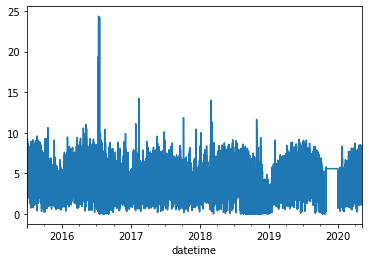

In [5]:
df0['speed'].plot()

In [9]:
# data_merge, data, forecast = prepare_data_with_forecast(data, keep_only_last=False)
def get_past_n_steps(df, steps_in):
    #rename column to most remote data
    df_out = df.copy().add_suffix('_t-'+str(steps_in))
    #t-i remote data
    for i in range(1, steps_in+1):
        df_temp = df.copy().add_suffix('_t-'+str(steps_in-i)) #rename column
        df_temp= df_temp.shift(periods=-i, axis=0) #shift down i row
        df_out=df_out.join(df_temp, how = 'inner')#join
    #shift index to present time (+steps_in)
    df_out['present_time']=df_out.index.to_series()+timedelta(hours=steps_in)
    df_out.set_index(pd.DatetimeIndex(df_out['present_time']), inplace=True)
    return df_out

df = get_past_n_steps(df0, 2)

In [10]:
def join_forecast(df, forecast, predict): 
    
    #crop out forecast if forecast period is less than prediction period
    forecast = forecast.loc[forecast['f_period']>= predict]
    forecast = prep.keep_last_forecast(forecast) 
    forecast = forecast.add_suffix('_forecast')    
    #calculate forecast_time
    df['forecast_time'] = df['present_time']+ timedelta(hours=predict)
    
    df_out = pd.merge(df, forecast, left_on = 'forecast_time', right_on ='f_date')
    return df_out 

def smooth_day_hour(df):
    df['cos_day'] = np.cos(2 * np.pi * df['present_time'].dt.day / 365)
    df['cos_hour'] =  np.cos(2 * np.pi * df['present_time'].dt.hour / 24)
    return df 

In [ ]:
#change x,y to array like 
def df_to_array(x_df, y_df):
    #drop timestamp columns
    x_df.drop(['present_time','forecast_time'], axis=1, inplace=True)
    y_df.drop(['forecast_time'], axis=1, inplace=True)
        
    x = x_df.values
    y = y_df.values 
    return x, y

In [28]:
#prepare x, y
def prepare_x_y(past_n_steps, pred_period, param):
    
    #get measurement data and forecast data: 
    measurement=prep.prepare_measurement()
    forecast = prep.prepare_forecast()
    measurement = measurement[['speed', 'cos_wind_dir', 'sin_wind_dir', 'temp', 'radiation', 'precip', 'season', 'am']]
    
    # concatenate past_n_steps data 
    df1=get_past_n_steps(measurement, past_n_steps)
    
    # add forecast data 
    x_df = join_forecast(df1, forecast, pred_period)
    
    #smooth day and hour
    x_df = smooth_day_hour(x_df)
    
    # define y accordingly 
    index = x_df['forecast_time'] 
    df2 = measurement[param] 
    y_df = pd.merge(df2, index, left_on = 'datetime', right_on='forecast_time' )
    
    #fillna: use last measurements 
    x_df.fillna(method='ffill', inplace=True)
    y_df.fillna(method='ffill', inplace=True) 

    #dropna
    x_df.dropna(axis=1, inplace=True)
    y_df.dropna(axis=1, inplace=True)
    
    #select intersection of the forecast times:
    index2= y_df['forecast_time']
    x_df = pd.merge(x_df, index2, left_on = 'forecast_time', right_on='forecast_time')
    
    #change df to array, drop datetime columns 
    x, y = df_to_array(x_df, y_df)
    return x_df, y_df, x, y 

x_df, y_df = prepare_x_y(3, 3, 'speed')
x_df

read csv semester csv files from 2015s2 to 2020s1
smooth wind direction
generate seasonality categorical feature
generate am/pm categorical feature
reading forecast data
smooth wind direction


,speed_t-3,cos_wind_dir_t-3,sin_wind_dir_t-3,temp_t-3,radiation_t-3,precip_t-3,season_t-3,am_t-3,speed_t-2,cos_wind_dir_t-2,...,present_time,forecast_time,speed_forecast,temp_forecast,rad_forecast,precip_forecast,cos_wind_dir_forecast,sin_wind_dir_forecast,cos_day,cos_hour
0,2.225000,0.850439,0.211122,20.725000,0.000000,0.00,3,1,2.900000,0.847033,...,2015-07-01 03:00:00,2015-07-01 06:00:00,0.981995,19.389978,0.000000,0.026673,0.981373,0.192114,0.999852,7.071068e-01
1,2.900000,0.847033,-0.517158,20.500000,0.000000,0.00,3,1,1.600000,0.929234,...,2015-07-01 04:00:00,2015-07-01 07:00:00,0.865024,19.629999,142.224380,0.025757,0.990156,0.139970,0.999852,5.000000e-01
2,1.600000,0.929234,-0.082164,20.675000,0.000000,0.00,3,1,2.175000,0.812413,...,2015-07-01 05:00:00,2015-07-01 08:00:00,0.851891,20.269983,342.239685,0.019653,0.998515,0.054470,0.999852,2.588190e-01
3,2.175000,0.812413,0.389547,20.850000,0.000000,0.00,3,1,2.625000,0.472097,...,2015-07-01 06:00:00,2015-07-01 09:00:00,0.995341,21.350031,526.759399,0.000000,0.984512,-0.175315,0.999852,6.123234e-17
4,2.625000,0.472097,0.850407,20.800000,0.000000,0.00,3,1,2.000000,0.387166,...,2015-07-01 07:00:00,2015-07-01 10:00:00,1.663903,22.800043,682.376343,0.011108,0.846408,-0.532535,0.999852,-2.588190e-01
5,2.000000,0.387166,0.910851,20.325000,0.750000,0.00,3,1,0.850000,0.910092,...,2015-07-01 08:00:00,2015-07-01 11:00:00,3.164305,24.029993,826.072510,0.000000,0.698033,-0.716065,0.999852,-5.000000e-01
6,0.850000,0.910092,0.254659,20.350000,25.250000,0.00,3,1,1.350000,0.572979,...,2015-07-01 09:00:00,2015-07-01 12:00:00,4.512950,24.589929,911.469543,0.000000,0.682370,-0.731007,0.999852,-7.071068e-01
7,1.350000,0.572979,0.224779,21.150000,110.750000,0.00,3,1,3.500000,0.475891,...,2015-07-01 10:00:00,2015-07-01 13:00:00,4.967552,24.670007,946.862732,0.000000,0.739689,-0.672949,0.999852,-8.660254e-01
8,3.500000,0.475891,-0.831353,21.775000,282.500000,0.00,3,1,5.675000,0.498544,...,2015-07-01 11:00:00,2015-07-01 14:00:00,5.060431,25.059961,929.840088,0.000000,0.798568,-0.601904,0.999852,-9.659258e-01
9,5.675000,0.498544,-0.865154,21.875000,467.000000,0.00,3,1,6.325000,0.382627,...,2015-07-01 12:00:00,2015-07-01 15:00:00,5.146431,25.220056,861.561707,0.000000,0.847576,-0.530675,0.999852,-1.000000e+00


In [24]:
# #check that the missing data gap is still there: 
# temp = x_df.copy()
# temp.set_index(['present_time'], inplace=True)
# temp['speed_t-0'].plot()
# plt.show()

# temp = y_df.copy()
# temp.set_index(['forecast_time'], inplace=True)
# temp['speed'].plot()
# plt.show()

read csv semester csv files from 2015s2 to 2020s1
smooth wind direction
generate seasonality categorical feature
generate am/pm categorical feature
reading forecast data
smooth wind direction


In [107]:
x, y = df_to_array(x_df, y_df)
x.shape, y.shape

((41194, 38), (41194, 1))

In [110]:
def scale_data_X_y(df_measurement, df_forecast, past_n_steps, pred_period, param='speed', test_size = 0.2):
    x_df, y_df = prepare_x_y(df_measurement, df_forecast, past_n_steps, pred_period, param)  
    X, y = df_to_array(x_df, y_df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle = False)
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1))
    y_train_scaled = y_train_scaled.reshape(-1)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1,1))
    y_test_scaled = y_test_scaled.reshape(-1)
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, X_train, X_test, y_train, y_test, scaler_X, scaler_y

In [118]:
_, _, _, _, X_train, X_test, y_train, y_test, _, _ = scale_data_X_y(df0, forecast, 24, 24, param='speed')

In [121]:
xg_speed = XGBRegressor(max_depth = 5)
xg_speed.fit(X_train, y_train)
y_hat = xg_speed.predict(X_test)

In [122]:
print("MSE speed is: ", mean_squared_error(y_test, y_hat))
print("MAE speed is: ", mean_absolute_error(y_test, y_hat))

MSE speed is:  0.9528414037720689
MAE speed is:  0.7530982699779175


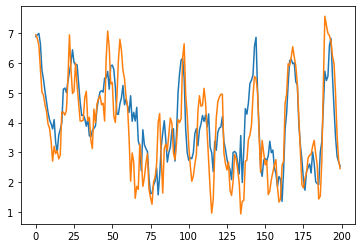

In [125]:
plt.plot(y_hat[:200]) 
plt.plot(y_test[:200])